In [4]:
# Import python libraries
#
import importlib
import pickle
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch.nn as nn
from matplotlib.patches import Rectangle
import seaborn as sns
import matplotlib.dates as mdates
from collections import defaultdict

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import models.Model as Model
import scripts.ModelAdapter as ModelAdapter


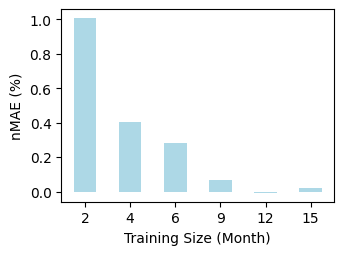

In [52]:
# Compare with and without transfer learning of the given configurations 
#

importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),       
    
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),  
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

models = ('xLSTM', 'LSTM', 'Transformer', )
configs_with_transfer = configs[0:6]
configs_without_transfer = configs[6:12]
training_sizes = ['2', '4', '6', '9', '12', '15']
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles[trainingSize][model][community_id]'
#
profiles_w_transfer = utils.Evaluate_Models.get_testrun_results(configs_with_transfer, resuts_filename, given_key = 'trainingSize', value_type = 'nMAE')
profiles_wo_transfer = utils.Evaluate_Models.get_testrun_results(configs_without_transfer, resuts_filename, given_key = 'trainingSize', value_type = 'nMAE')

# Calculate the average improvement with tranfer learning
#
improvements = []
for trainingsize in profiles_w_transfer:
        deltas = []
        for model in profiles_w_transfer[trainingsize]:
                for community_id in range(len(profiles_w_transfer[trainingsize][model])):
                        deltas.append(profiles_wo_transfer[trainingsize][model][community_id] \
                                - profiles_w_transfer[trainingsize][model][community_id])
        mean_per_config = np.mean(deltas)
        improvements.append(np.mean(deltas))

# Bar plot
x = np.arange(len(training_sizes))
fig_width_inch = 90 / 25.4
fig_height_inch = fig_width_inch * 0.75
fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch))
ax.bar(x, improvements, color='lightblue', width=0.5)
ax.set_xlabel('Training Size (Month)', fontsize=10)
ax.set_ylabel('nMAE (%)', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(training_sizes)
plt.tight_layout()
fig.savefig('scripts/outputs/figs/Fig_transfer_learning_over_train_size.pdf', format='pdf')
plt.show()


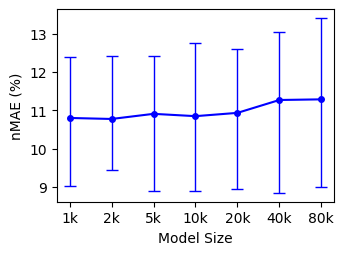

In [89]:
# Compare the effect of the model sizes
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
configs = [
    Config_of_one_run(ModelSize._1k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._2k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._10k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._20k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._40k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._80K, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]
model = 'Transformer'
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles[modelSize][model][community_id]'
#
profiles = utils.Evaluate_Models.get_testrun_results(configs, resuts_filename, given_key = 'modelSize', value_type = 'nMAE')

# Calculate the average improvement with tranfer learning
#
mean_values, min_values, max_values = [], [], []
modelSizes = []
for modelSize in profiles:
        modelSizes.append(modelSize)
        values = profiles[modelSize][model]
        assert len(values) == 20, f'Unexpected nr of communities: {len(values)}'
        mean_values.append(np.mean(values))
        min_values.append(np.min(values))
        max_values.append(np.max(values))

# Calculate asymmetric errors
lower_errors = np.array(mean_values) - np.array(min_values)
upper_errors = np.array(max_values) - np.array(mean_values)
asymmetric_errors = [lower_errors, upper_errors]

# Define figure size (inches) - Elsevier standard ~90 mm width for single column
fig_width_inch = 90 / 25.4
fig_height_inch = fig_width_inch * 0.75

fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch))

# Plot with error bars
ax.errorbar(modelSizes, mean_values, yerr=asymmetric_errors,
            fmt='o-', capsize=4, elinewidth=1, markeredgewidth=1,
            color='blue', ecolor='blue', markersize=4)
ax.set_xlabel('Model Size', fontsize=10)
ax.set_ylabel('nMAE (%)', fontsize=10)
plt.tight_layout()
plt.savefig('scripts/outputs/figs/Fig_performance_over_model_size.pdf', format='pdf')
plt.show()


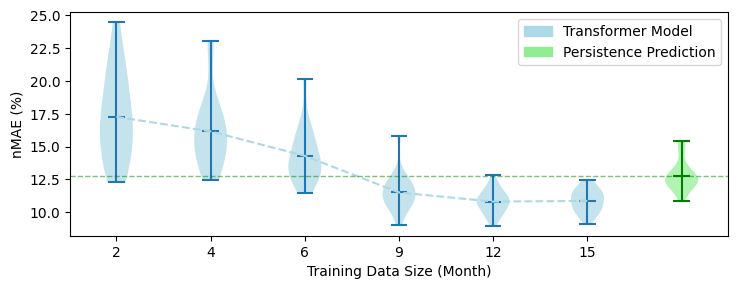

In [ ]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    value_type = 'nMAE')

configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),       
]

# Constants and Configuration
# machine_learning_models = ('xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
machine_learning_models = ('Transformer_Encoder_Only', )
basic_model = 'PersistencePrediction'
training_sizes = ['2', '4', '6', '9', '12', '15']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model and transfer condition
data_with_ML_models = {model: get_full_data_list(model, configs, result_dict) for model in machine_learning_models}
data_with_basic_model = get_full_data_list(basic_model, configs, result_dict)[0]


# Creating subplots for violin plots
fig_width_inch = 190 / 25.4
fig_height_inch = fig_width_inch /2.5 * len(machine_learning_models)
fig, axes = plt.subplots(len(machine_learning_models), 1, figsize=(fig_width_inch, fig_height_inch), sharex=True, sharey=True)

# Plot each model's data on a separate subplot
for idx, model in enumerate(machine_learning_models):
    
    if len(machine_learning_models) > 1:
        ax = axes[idx]
    else:
        ax = axes
    
    # Get data for each training size
    data_with_ML_model = data_with_ML_models[model]
        
    # Without Transfer Learning violins
    positions = np.array(range(len(training_sizes))) * 2.0   
    violins_ml_model = ax.violinplot(data_with_ML_model, positions=positions, widths=0.7, 
                                    showmeans=True, showextrema=True, showmedians=False) 
    # With Transfer Learning violins    
    violins_basic_models = ax.violinplot(data_with_basic_model, positions=[positions[0] + 12], widths=0.7, 
                                 showmeans=True, showextrema=True, showmedians=False)
          
    # Connect the means
    data_with_ML_model = np.array(data_with_ML_models[model])
    mean_data_with_ML_model = np.mean(data_with_ML_model, axis=1)
    ax.plot(positions, mean_data_with_ML_model, label=f'{model} Model',
             linestyle='--', marker='', color='lightblue')  # training_sizes,        

    # Set custom colors for the violins by modifying each PolyCollection
    for pc in violins_ml_model['bodies']:
        pc.set_facecolor("lightblue")
        pc.set_alpha(0.7)
    for pc in violins_basic_models['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_alpha(0.7)        
    
    # Customize vertical lines
    violins_basic_models['cmeans'].set_color('green')   # Change the color of the mean lines
    violins_basic_models['cmins'].set_color('green')   # Change the color of the minimum lines
    violins_basic_models['cmaxes'].set_color('green')  # Change the color of the maximum lines
    violins_basic_models['cbars'].set_color('green')  # Change the color of the vertical bars (connectors)
    
    # Add horizontal lines for the computed min, max, and mean
    min_basic = min(data_with_basic_model)
    max_basic = max(data_with_basic_model)
    mean_basic = np.mean(data_with_basic_model)    
    ax.axhline(mean_basic, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Mean of Basic Model')
            
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    ax.set_axisbelow(True)
    
    # Add legend to each subplot
    if model == 'Transformer_Encoder_Only':
        model = 'Transformer'  # Rename
    legend_patches = [
        Patch(color="lightblue", label=f"{model} Model"),
        Patch(color="lightgreen", label="Persistence Prediction")
    ]
    ax.legend(handles=legend_patches, loc="upper right")

if len(machine_learning_models) > 1:
    axes[-1].set_xlabel('Training Data Size (Month)')
else:
    axes.set_xlabel('Training Data Size (Month)')

plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_ML_model_vs_persistence_prediction.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()



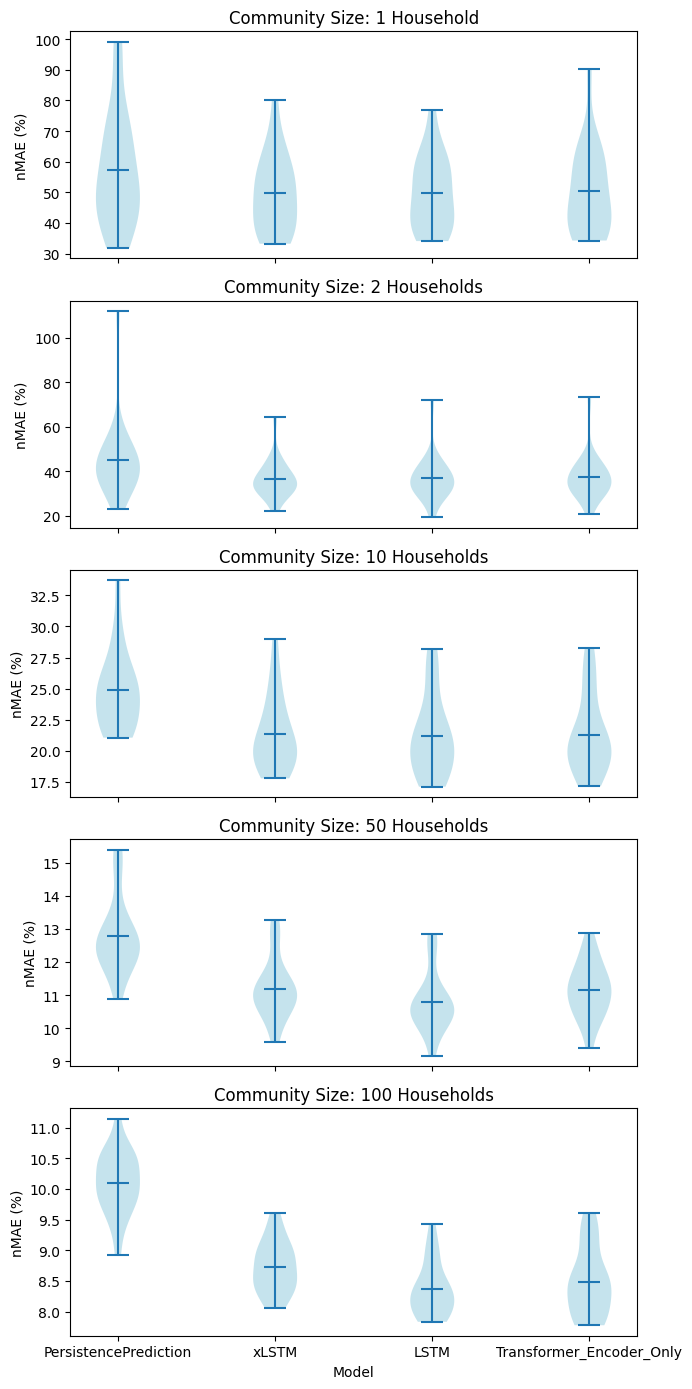

In [ ]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    value_type = 'nMAE')

configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]

# Constants and Configuration
models = ('PersistencePrediction', 'xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
household_sizes = ['1', '2', '10', '50', '100']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
full_data_list = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Transpose data for each household size
data_by_household_size = {}
for i, size in enumerate(household_sizes):
    data_by_household_size[size] = [full_data_list[model][i] for model in models]

# Creating subplots for each household size
fig, axes = plt.subplots(len(household_sizes), 1, figsize=(7, 2.8*5), sharex=True, sharey=False)

# Plot each household size's data on a separate subplot
for idx, (size, data) in enumerate(data_by_household_size.items()):
    ax = axes[idx]
    
    # Plot violin plot
    positions = np.array(range(len(models)))
    violins = ax.violinplot(data, positions=positions, widths=0.28, 
                            showmeans=True, showextrema=True, showmedians=False)
    
    for pc in violins['bodies']:
        pc.set_facecolor("lightblue")
        # pc.set_edgecolor("black")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    if idx == 0:
        ax.set_title(f"Community Size: {size} Household")
    else:
        ax.set_title(f"Community Size: {size} Households")
    # ax.text(0.5, 0.9, f"Community Size: {size} households", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(models)
    ax.set_axisbelow(True)
    # ax.grid(True, color="0.9")
    # ax.set_ylim(0, None)

    # Set x-axis label for the last plot
    if idx == len(household_sizes) - 1:
        ax.set_xlabel('Model')

plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_error_over_community_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


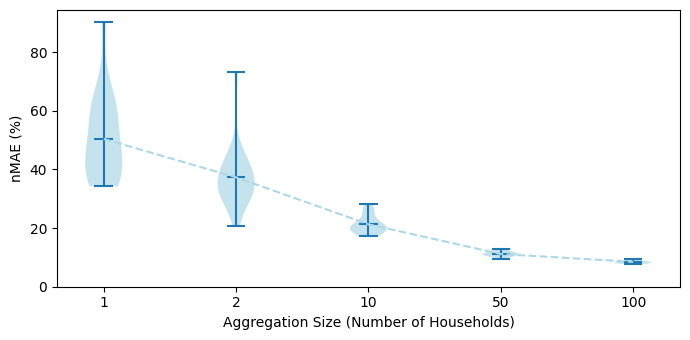

In [ ]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    value_type = 'nMAE')

configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]

# Constants and Configuration
models = ('PersistencePrediction', 'xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
household_sizes = ['1', '2', '10', '50', '100']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
full_data_list = {model: get_full_data_list(model, configs, result_dict) for model in models}
data = full_data_list['Transformer_Encoder_Only']

# Creating subplots for each household size
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), sharex=True, sharey=False)
    
# Plot violin plot
positions = np.array(range(len(household_sizes)))
violins = ax.violinplot(data, positions=positions, widths=0.28, 
                        showmeans=True, showextrema=True, showmedians=False)

for pc in violins['bodies']:
    pc.set_facecolor("lightblue")
    # pc.set_edgecolor("black")
    pc.set_alpha(0.7)
    
# Connect the means
data_with_ML_model = np.array(data)
mean_data_with_ML_model = np.mean(data_with_ML_model, axis=1)
ax.plot(positions, mean_data_with_ML_model, linestyle='--', marker='', color='lightblue')
    
# Labels and title
ax.set_ylabel('nMAE (%)')
# ax.set_title(f"Transformer Model")
# ax.text(0.5, 0.9, f"Transformer Model", transform=ax.transAxes, fontsize=12, ha="center", va="center")
ax.set_xticks(positions)
ax.set_xticklabels(household_sizes)
ax.set_axisbelow(True)
# ax.grid(True, color="0.9")
ax.set_ylim(0, None)
ax.set_xlabel('Aggregation Size (Number of Households)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_error_over_community_size2.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


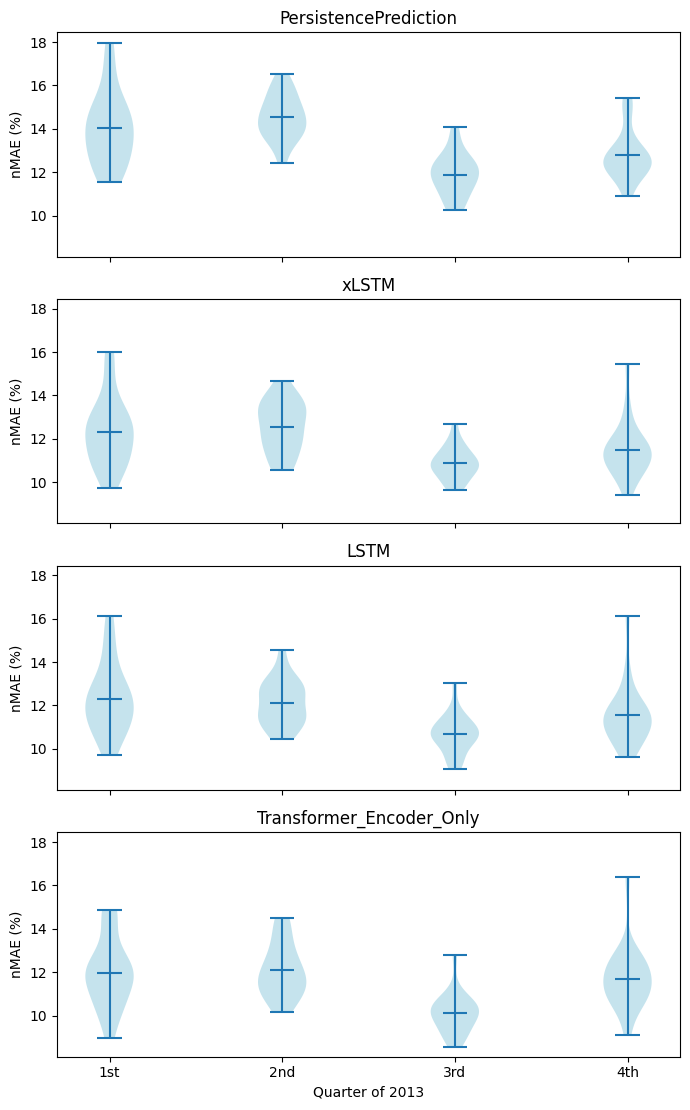

In [ ]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    value_type = 'nMAE')

# Define, which configurations to print
# 
configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._0_MONTH, TestSize._3_MONTH, TrainingFuture._9_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._3_MONTH, TestSize._3_MONTH, TrainingFuture._6_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._3_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]
models = ('PersistencePrediction', 'xLSTM', 'LSTM', 'Transformer_Encoder_Only', )
tested_quartals = ['1st', '2nd', '3rd', '4th']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
data_by_model = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Creating subplots
fig, axes = plt.subplots(len(data_by_model), 1, figsize=(7, 2.8*4), sharex=True, sharey=True)

# Plot each quartal's data on a separate subplot
for idx, (model, data) in enumerate(data_by_model.items()):
    ax = axes[idx]
    
    # Plot violin plot
    positions = np.array(range(len(models)))
    violins = ax.violinplot(data, positions=positions, widths=0.28, 
                            showmeans=True, showextrema=True, showmedians=False)
    
    for pc in violins['bodies']:
        pc.set_facecolor("lightblue")
        # pc.set_edgecolor("black")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')    
    ax.set_title(f"{model}")
    # ax.text(0.5, 0.9, f"Tested Quartal: {quartal}", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(tested_quartals)
    ax.set_axisbelow(True)
    # ax.grid(True, color="0.9")
    
    # Set x-axis label for the last plot
    if idx == len(tested_quartals) - 1:
        ax.set_xlabel('Quarter of 2013')

plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_error_over_tested_quartals.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


In [ ]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    value_type = 'nMAE')

printed_configs = [

    # Vary the model sizes
    Config_of_one_run(ModelSize._1k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._2k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._10k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._20k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._40k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._80K, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    
   # Vary the tested quartals
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._3_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._3_MONTH, TestSize._3_MONTH, TrainingFuture._6_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._0_MONTH, TestSize._3_MONTH, TrainingFuture._9_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),

   # Vary the train set size
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Create Table "with Transfer Learning"
config_names = ['1k', '2k', '5k', '10k', '20k', '40k', '80k', 
                'Q1', 'Q2', 'Q3', 'Q4',
                '1', '2', '10', '50', '100',
                '2 mo', '4 mo', '6 mo', '9 mo', '12 mo', '15 mo',
                ]
config_groups = [{'name':'Model Size', 'rows':7}, '-', '-', '-', '-', '-', '-', 
                {'name':'Testset<br>(2013)', 'rows':4}, '-', '-', '-',
                {'name':'Community<br>Size', 'rows':5}, '-', '-', '-', '-',
                {'name':'Training Size', 'rows':6}, '-', '-', '-', '-', '-',
                ]
configs_with_transfer_learning = printed_configs[:len(config_names)]
assert len(config_names) == len(config_groups) == len(configs_with_transfer_learning), \
        f"Unexpected list length: {len(config_names)} != {len(config_groups)} != {len(configs_with_transfer_learning)}"
utils.Evaluate_Models.print_latex_table(result_dict, configs_with_transfer_learning, config_groups, config_names)



# Without transfer learning:
#

printed_configs = [
    
    # Vary the train set size
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Create Table "without Transfer Learning"
config_names = [
                '2 mo', '4 mo', '6 mo', '9 mo', '12 mo', '15 mo',
                ]
config_groups = [
                {'name':'Training Size', 'rows':6}, '-', '-', '-', '-', '-',
                ]
assert len(config_names) == len(config_groups) == len(printed_configs), \
        f"Unexpected list length: {len(config_names)} != {len(config_groups)} != {len(printed_configs)}"
utils.Evaluate_Models.print_latex_table(result_dict, printed_configs, config_groups, config_names)


\hline
\multirow{7}{*}{\rotatebox[origin=c]{90}{\textbf{Model Size}}} 
    & 1k & 11.24 (0.93) & 12.79 (1.13) & 10.86 (1.00) & 12.24 (1.00) & \textbf{10.85} (0.83) \\ 
    & 2k & 11.24 (0.93) & 12.79 (1.13) & 10.90 (1.04) & \textbf{10.79} (0.92) & 10.80 (0.81) \\ 
    & 5k & 11.24 (0.93) & 12.79 (1.13) & 10.94 (0.86) & \textbf{10.70} (0.82) & 10.94 (0.93) \\ 
    & 10k & 11.24 (0.93) & 12.79 (1.13) & 11.44 (0.83) & \textbf{10.75} (0.87) & 10.80 (0.90) \\ 
    & 20k & 11.24 (0.93) & 12.79 (1.13) & 11.86 (0.85) & 11.29 (0.97) & \textbf{10.93} (0.96) \\ 
    & 40k & \textbf{11.24} (0.93) & 12.79 (1.13) & 12.61 (1.01) & 11.88 (1.05) & 11.27 (1.01) \\ 
    & 80k & 11.24 (0.93) & 12.79 (1.13) & 12.65 (0.98) & 12.29 (1.23) & \textbf{11.18} (1.01) \\ 
\hline
\multirow{4}{*}{\rotatebox[origin=c]{90}{\shortstack{\textbf{Testset} \\ \textbf{(2013)}}}} 
    & Q1 & 12.59 (1.09) & 12.79 (1.13) & \textbf{11.38} (1.14) & 11.49 (1.16) & 11.76 (1.54) \\ 
    & Q2 & 11.96 (1.09) & 11.89 (0.97) & 10.75 (0

torch.Size([92])
nMAE = 6.9% of community 0 on test day 0.
nMAE = 4.8% of community 0 on test day 3.
nMAE = 28.5% of community 0 on test day 86.
nMAE = 30.7% of community 0 on test day 87.


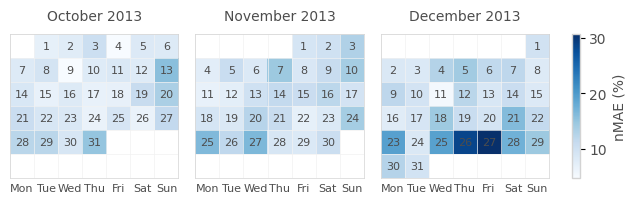

In [26]:
# Create Calendar Plot
#

importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
expected_configs = Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                    NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)
model_type = 'Transformer_Encoder_Only'
community_id = 0
startdate = pd.Timestamp('2013-10-01 00:00:00+00:00')
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles_by_community_size[community_size][model][community_id]'
#
profiles_by_community_size = utils.Evaluate_Models.get_testrun_results([expected_configs], resuts_filename)

# Calculate the daily nMAE
#
Y_pred = profiles_by_community_size[expected_configs.aggregation_Count[0]][model_type][community_id]
Y_real = profiles_by_community_size[expected_configs.aggregation_Count[0]]['Perfect'][community_id]
Y_pred = torch.tensor(Y_pred.reshape((-1, 24)))
Y_real = torch.tensor(Y_real.reshape((-1, 24)))
loss_fn = nn.L1Loss(reduction='none')
nMAE = (loss_fn(Y_pred, Y_real).mean(dim=1)) / torch.mean(Y_real).item()
nMAE *= 100    # Convert to %
print(nMAE.shape)

# Print daily nMAE results of chosen community
#
test_day_nrs = [0, 3, 86, 87]
for test_day_nr in test_day_nrs:
    print(f"nMAE = {nMAE[test_day_nr].item():.1f}% " \
          f"of community {community_id} on test day {test_day_nr}.")

# Create plot
#
utils.Evaluate_Models.create_calendar_plot(startdate, nMAE)



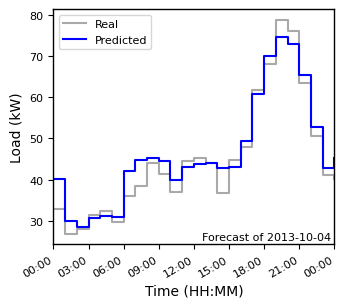

In [23]:
# Create Step Plot
#

########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
expected_configs = Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                    NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)
model_type = 'Transformer_Encoder_Only'
community_id = 0
startdate = pd.Timestamp('2013-10-01 00:00:00+00:00')
day_to_plot = '2013-10-04'
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles_by_community_size[community_size][model][community_id]'
#
profiles_by_community_size = utils.Evaluate_Models.get_testrun_results([expected_configs], resuts_filename)

# Calculate the daily nMAE
#
Y_pred = profiles_by_community_size[expected_configs.aggregation_Count[0]][model_type][community_id]
Y_real = profiles_by_community_size[expected_configs.aggregation_Count[0]]['Perfect'][community_id]

# Create dataframe
datetime_index = pd.date_range(start=startdate, periods=Y_real.shape[0], freq='1h')
df_Y_plot = pd.DataFrame()
df_Y_plot['x'] = datetime_index
df_Y_plot['Y_real'] = Y_real / 1000.0
df_Y_plot['Y_pred'] = Y_pred / 1000.0

# Plot only given Day
day_start = pd.to_datetime(day_to_plot).tz_localize('UTC')
day_end = day_start + pd.Timedelta(days=1)
mask = (df_Y_plot['x'] >= day_start) & (df_Y_plot['x'] <= day_end)
df_Y_plot_day = df_Y_plot[mask]

# Create Step-Plot
fig_width_inch = 90 / 25.4
fig_height_inch = fig_width_inch * 0.9
fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch))
ax.step(df_Y_plot_day['x'], df_Y_plot_day['Y_real'], where='post', label='Real', color='darkgrey')
ax.step(df_Y_plot_day['x'], df_Y_plot_day['Y_pred'], where='post', label='Predicted', color='blue')
ax.set_ylabel(f'Load (kW)', fontsize=10)
ax.set_xlabel(f'Time (HH:MM)', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
ax.legend(loc='upper left', fontsize=8)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(day_start, day_end)
fig.autofmt_xdate()

# Datum der Vorhersage in den Plot schreiben
ax.text(0.99, 0.01, f'Forecast of {day_to_plot}', 
        transform=ax.transAxes,
        ha='right', va='bottom',
        fontsize=8, color='black')

# Save plot
plt.tight_layout()
fig.savefig('scripts/outputs/figs/Fig_matplotlib_profile_Y.pdf', format='pdf', dpi=300)
plt.show()


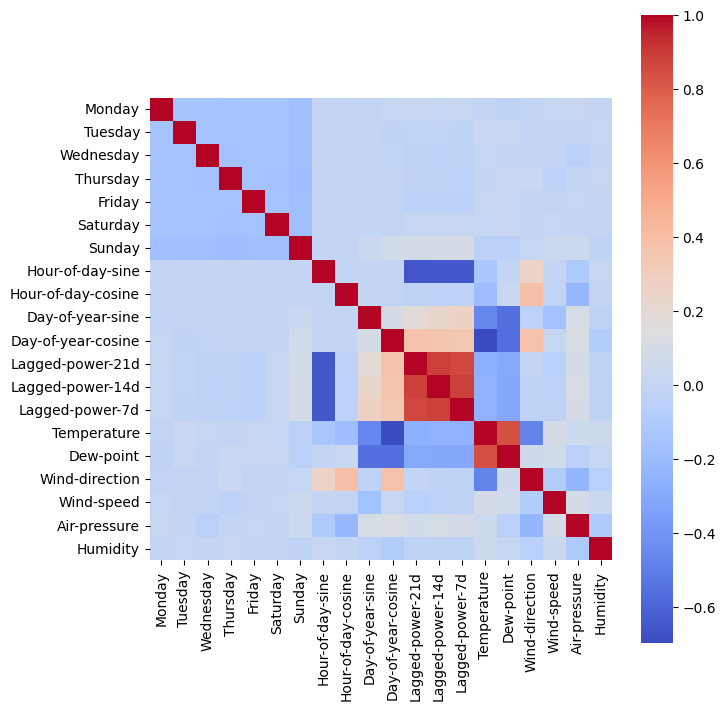

In [91]:
# Evaluate specific model of given power profiles and given configurations
#

importlib.reload(Visualization)
importlib.reload(Model)
importlib.reload(utils)
importlib.reload(ModelAdapter)

# Define a specific configuration
#
community_id = 0  # chose one of many energy communites
myConfig = Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                            trainHistory = myConfig.trainingHistory,
                                            testSize = myConfig.testSize, 
                                            trainFuture = myConfig.trainingFuture, 
                                            devSize = myConfig.devSize, 
                                            )
X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
X['all']

batch, timesteps, features = X['all'].shape

# Flatten across batch and timesteps
x_flat = X['all'].reshape(batch * timesteps, features)
y_flat = Y['all'].reshape(batch * timesteps)

feature_names = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'Hour-of-day-sine', 'Hour-of-day-cosine', 'Day-of-year-sine', 'Day-of-year-cosine',
    'Lagged-power-21d', 'Lagged-power-14d', 'Lagged-power-7d',
    'Temperature', 'Dew-point', 'Wind-direction', 'Wind-speed', 'Air-pressure', 'Humidity',
]
assert features == len(feature_names)

df = pd.DataFrame(x_flat, columns=feature_names)
df['Target'] = y_flat

# Compute correlation matrix (excluding the target if needed)
corr_matrix = df.drop(columns=['Target']).corr()
# corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(7.48, 7.48))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True)
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_confusion_matrix.pdf", format="pdf", bbox_inches="tight")
plt.show()


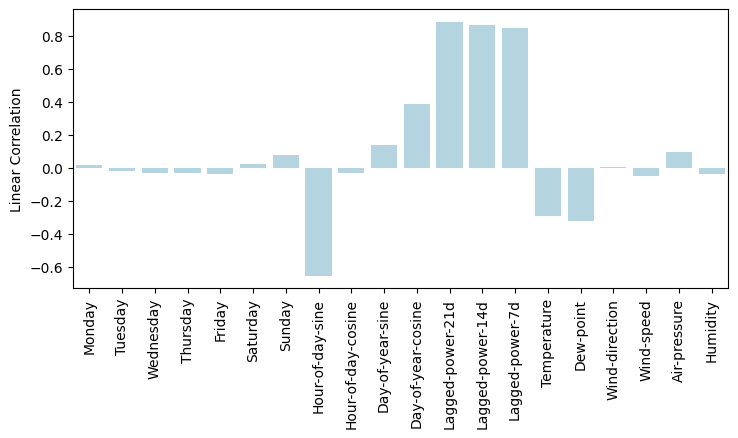

In [114]:
# Compute full correlation matrix
corr = df.corr(numeric_only=True)

# Extract just correlations with the target
target_corr = corr['Target'].drop('Target')  # drop self-correlation

# Convert to DataFrame for nice plotting
target_corr_df = target_corr.to_frame().rename(columns={'Target': 'correlation'})

# Plot as barplot
fig_width_inch = 190 / 25.4
fig_height_inch = fig_width_inch * 0.6
plt.figure(figsize=(fig_width_inch, fig_height_inch))
sns.barplot(x=target_corr_df.index, y=target_corr_df.correlation, color='lightblue')
plt.xticks(rotation=90)
plt.ylabel("Linear Correlation")
plt.xlabel("")
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Fig_target_correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()
